# Projekt
Zbiór danych: https://archive.ics.uci.edu/ml/datasets/Polish+companies+bankruptcy+data

In [33]:
import os

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, roc_auc_score, roc_curve, auc, f1_score, classification_report, ConfusionMatrixDisplay, precision_recall_curve, PrecisionRecallDisplay
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier
import xgboost

import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=ConvergenceWarning)
# warnings.simplefilter(action='ignore', category=UserWarning)

plt.rcParams['figure.figsize'] = (16,6)
sns.set(font_scale = 1.2)
sns.set_style("ticks",{'axes.grid' : True})
sns.set_palette("deep")

## Wczytanie danych

In [2]:
df = pd.read_csv(os.path.join('data', 'dataset.csv'))
df.head()

,Attr1,Attr2,Attr3,Attr4,Attr5,Attr6,Attr7,Attr8,Attr9,Attr10,...,Attr58,Attr59,Attr60,Attr61,Attr62,Attr63,Attr64,class,bankruptcy_after,year
0,0.200550,0.37951,0.39641,2.0472,32.3510,0.38825,0.249760,1.33050,1.1389,0.50494,...,0.87804,0.001924,8.4160,5.1372,82.658,4.4158,7.4277,0,0,1
1,0.209120,0.49988,0.47225,1.9447,14.7860,0.00000,0.258340,0.99601,1.6996,0.49788,...,0.85300,0.000000,4.1486,3.2732,107.350,3.4000,60.9870,0,0,1
2,0.248660,0.69592,0.26713,1.5548,-1.1523,0.00000,0.309060,0.43695,1.3090,0.30408,...,0.76599,0.694840,4.9909,3.9510,134.270,2.7185,5.2078,0,0,1
3,0.081483,0.30734,0.45879,2.4928,51.9520,0.14988,0.092704,1.86610,1.0571,0.57353,...,0.94598,0.000000,4.5746,3.6147,86.435,4.2228,5.5497,0,0,1
4,0.187320,0.61323,0.22960,1.4063,-7.3128,0.18732,0.187320,0.63070,1.1559,0.38677,...,0.86515,0.124440,6.3985,4.3158,127.210,2.8692,7.8980,0,0,1


## Podsumowanie po KM1
* firmy, które zbankrutowały, stanowią niewielką liczbę wszystkich obserwacji, ok. 5%
* możemy usunąć kolumny `X27`, `X21`, `X37` ze względu na dużą liczbę braków danych
* możemy usunąć w większości puste wiersze
* należy zapełnić braki danych w kolumnach, ponieważ każda kolumna pewne braki ma; najlepiej przez medianę, ze względu na wartości odstające
* żadna kolumna nie wydaje się być szczególnie mocno skorelowana z naszymi docelowymi kategoriami
* istnieją grupy bardzo mocno skorelowanych zmiennych; można rozważyć zostawienie tylko jednej kolumny z każdej grupy
* można rozważyć noramlizację zmiennych, ponieważ występuja one w różnych rzędach wielkości 
* wszystkie zmienne mają bardzo dużo wartości odstających oraz koncentrują się w okolicach zera (poza `X27`)
* nie możemy usunąć obserwacji o wielu wartościach odstających, ponieważ byśmy pozbyli się wielu firm, które zbankrutowały

# Kamień milowy 2

## Przygotowanie danych

In [7]:
y = df['class']
y2 = df['bankruptcy_after']
X = df.drop(['class', 'bankruptcy_after', 'year'], axis = 1)

#### Usuwanie kolumn zawierających dużo braków danych

In [8]:
X = X.drop(["Attr27","Attr21","Attr37"], axis = 1)

#### Usuwanie kolumn silnie skorelowane z innymi
Usuwamy wszystkie kolumny silnie skorelowane z innymi. Zosatwiamy po jednej kolumnie z każdej grupy.

In [9]:
## pierwszy model zadziałał lepiej bez tego;
## teraz to jest Transformer, można dodawać opcjonalnie

class OutlierCutter(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        columns_to_drop = ['Attr51', 'Attr2','Attr50', 'Attr4','Attr14', 'Attr18', 'Attr7', 'Attr8', 'Attr36', 'Attr63', 'Attr9', 'Attr10', 'Attr26', 'Attr12', 'Attr31', 'Attr19','Attr43', 'Attr44', 'Attr49', 'Attr56', 'Attr58', 'Attr20','Attr48', 'Attr63', 'Attr22', 'Attr52', 'Attr32', 'Attr34','Attr64', 'Attr53']
        return X.drop(columns_to_drop, axis = 1)

#### Usunięcie wierszy, ktore mają conajmniej 7 braków danych.

In [10]:
y = y[X.isna().sum(axis=1) <= 7]
y2 = y2[X.isna().sum(axis=1) <= 7]
X = X[X.isna().sum(axis=1) <= 7]

#### Braki danych
Zastępujemy braki danych w kolumnach medianą z poszczególnych zmiennych.

In [11]:
X.fillna(X.median(), inplace=True)

#### Przycinanie outlierów
Przycięcie (nie usunięcie!) wartości odstających, tzn. 2% na wartości najmniejszych i największych sprowadzone do odpowiednich "kwanyli" rzędu 0.02 i 0.98

In [12]:
Q_02 = X.quantile(0.02)
Q_98 = X.quantile(0.98)
for col in X.columns:
    X.loc[X[col] < Q_02[col], col] = Q_02[col]
    X.loc[X[col] > Q_98[col], col] = Q_98[col]

#### Normalizacja zmiennych

In [13]:
for col in X:
    transf = X[col].values.reshape(-1,1)
    scaler = StandardScaler().fit(transf)
    X[col] = scaler.transform(transf)

#### Dodanie kolumny informującej o liczbie wartości odstających w wierszu

In [14]:
Q1 = X.quantile(0.25)
Q3 = X.quantile(0.75)
IQR = Q3 - Q1
X['outliers_count'] = ((X < (Q1 - 1.5*IQR)) | (X > (Q3 + 1.5*IQR))).sum(axis=1)

### Podział danych na zbiory treningowy, testowy i walidcyjny
Podział w proporcji 60% / 20% / 20%. Zbiór walidcyjny będzie zachowany do finlalnej ewalucji modelu.

In [15]:
X

,Attr1,Attr2,Attr3,Attr4,Attr5,Attr6,Attr7,Attr8,Attr9,Attr10,...,Attr56,Attr57,Attr58,Attr59,Attr60,Attr61,Attr62,Attr63,Attr64,outliers_count
0,0.921360,-0.409273,0.650514,-0.189336,0.117814,1.445342,1.064629,-0.288025,-0.487848,0.086002,...,0.277158,0.597884,-0.292476,-0.400173,-0.321922,-0.445583,-0.166694,-0.408969,-0.211351,2
1,0.978979,-0.009248,0.903404,-0.222416,0.048541,-0.093332,1.117644,-0.367665,0.015922,0.062476,...,0.273015,0.653003,-0.452271,-0.403036,-0.402151,-0.624724,0.094528,-0.553983,1.559376,4
2,1.244822,0.642250,0.219427,-0.348247,-0.014317,-0.093332,1.431042,-0.500773,-0.335019,-0.583308,...,1.025392,1.612806,-1.007536,0.631175,-0.386316,-0.559583,0.379320,-0.651272,-0.284743,6
3,0.120825,-0.649115,0.858521,-0.045529,0.195116,0.500658,0.094183,-0.160503,-0.561343,0.314559,...,-0.149413,-0.017764,0.141091,-0.403036,-0.394142,-0.591904,-0.126736,-0.436521,-0.273439,1
4,0.832409,0.367447,0.094282,-0.396172,-0.038612,0.649036,0.678813,-0.454643,-0.472575,-0.307767,...,0.358084,0.808151,-0.374735,-0.217818,-0.359852,-0.524524,0.304631,-0.629759,-0.195802,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43400,-0.340299,0.676447,-0.541755,-0.471722,-0.084338,-0.093332,-0.392245,-0.505761,-0.004563,-0.617597,...,-0.361904,-0.254664,0.563682,1.471475,-0.226868,0.255486,-0.521531,0.021518,-0.381543,3
43401,-2.926763,1.543195,-2.761088,-0.746879,-0.275446,-2.384202,-2.759900,-0.680407,-0.666742,-2.896270,...,-0.890790,3.212200,0.894888,-0.429953,1.601431,3.362283,-0.181907,-0.397805,-0.287299,20
43402,-1.630841,2.501233,-1.591620,-0.609417,-0.484764,-0.802925,-1.435942,-0.666755,-0.455504,-2.684841,...,0.446167,0.962431,-0.464269,-1.180630,-0.294914,-0.603965,1.157950,-0.788691,-0.127872,8
43403,-1.158926,0.801835,-0.619810,-0.498960,-0.076829,-0.524755,-1.153254,-0.574973,-0.751764,-1.285927,...,-1.638691,-3.178582,1.654939,4.858902,-0.219084,-0.355273,-0.161785,-0.412495,-0.425320,13


In [16]:
X_train_test, X_val, y_train_test, y_val = train_test_split(X, y, random_state=2137, test_size=0.2, stratify=y)
X_train, X_test, y_train, y_test = train_test_split(X_train_test, y_train_test, random_state=420, test_size=0.25, stratify=y_train_test)

## Modelowanie klasyfikatorów

### Miary oceny jakości klasyfikatora
* precision / recall / f1 score
* confusion matrix
* roc auc
* ??

In [17]:
## procedury pomocnicze

# precision / recall
def print_precision_recall_report(clf, X_train, y_train, X_test, y_test):
    y_train_pred = clf.predict(X_train)
    y_test_pred = clf.predict(X_test)

    # tabelki precision / recall / f1
    def print_precision_recall_table(y, y_pred, title='Zbiór ...'):
        print('{:-^29}'.format(title))
        print(pd.DataFrame(classification_report(
                y, y_pred,
                output_dict = True
            )).iloc[:-1, :-3].to_string())
        print()

    print_precision_recall_table(y_train, y_train_pred, 'Zbiór treningowy')
    print_precision_recall_table(y_test, y_test_pred, 'Zbiór testowy')

    # macierz pomyłek
    def plot_confusion_matrix(y, y_pred, title, ax):
        conf_mx = confusion_matrix(y, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=conf_mx, display_labels=[0, 1])
        disp.plot(colorbar=False, cmap=plt.cm.Blues, ax=ax, values_format='d')
        ax.grid(False)
        ax.set_title(title)
        
    fig, axs = plt.subplots(1, 2, figsize=(8, 4))
    plot_confusion_matrix(y_train, y_train_pred, 'Zbiór treningowy', axs[0])
    plot_confusion_matrix(y_test, y_test_pred, 'Zbiór testowy', axs[1])
    axs[1].set_ylabel(None)
    plt.show()
    
# roc auc
def plot_roc_auc(clf, X_train, y_train, X_test, y_test):
    def fpr_tpr_rocauc(X, y):
        y_score = clf.decision_function(X)
        fpr, tpr, _ = roc_curve(y, y_score)
        roc_auc = auc(fpr, tpr)
        return (fpr, tpr, roc_auc)
    
    fpr_train, tpr_train, roc_auc_train = fpr_tpr_rocauc(X_train, y_train)
    fpr_test, tpr_test, roc_auc_test = fpr_tpr_rocauc(X_test, y_test)

    plt.figure(figsize=(6, 6))
    plt.plot(fpr_train, tpr_train, color="steelblue", lw=2, label="Train ROC curve (area = %0.2f)" % roc_auc_train)
    plt.plot(fpr_test, tpr_test, color="darkorange", lw=2, label="Test ROC curve (area = %0.2f)" % roc_auc_test)

    plt.plot([0, 1], [0, 1], color="black", lw=2, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Krzywa ROC")
    plt.legend(loc="lower right")
    plt.show()

### Regresja logistyczna ❤️
(przekopiowałem sobie z innej pracy)

In [18]:
clf = LogisticRegression().fit(X_train, y_train)
clf.score(X_train, y_train)

0.9540083410565339

In [16]:
clf.score(X_test, y_test)

0.9543558850787767

Widzimy, że osiągany *score* jest bardzo podejrzanie wysoki. Spójrzmy zatem na inne miary oceny jakości klasyfikatora.

------Zbiór treningowy-------
                  0         1
precision  0.954864  0.747664
recall     0.998905  0.064309
f1-score   0.976388  0.118431

--------Zbiór testowy--------
                  0         1
precision  0.955408  0.744186
recall     0.998661  0.077108
f1-score   0.976556  0.139738



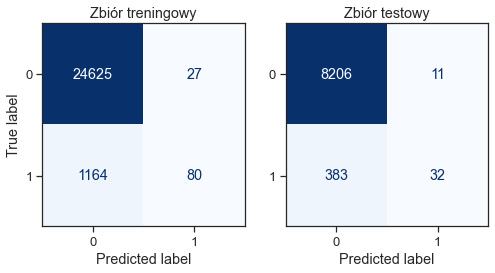

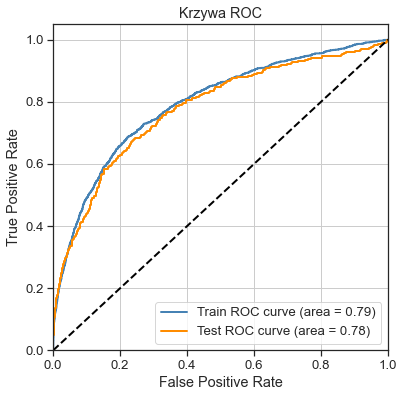

In [17]:
print_precision_recall_report(clf, X_train, y_train, X_test, y_test)
plot_roc_auc(clf, X_train, y_train, X_test, y_test)

Sytuacja nie jest bardzo kolorowa. Model bardzo błędnie klasyfikuje firmy, które faktycznie zbankrutowały (niski *recall*). Ponadto, w tym przypadku krzywa ROC wydaje się mało użyteczna, poniważ przypadki *false positve* są mniejszym problemem. 

Główną przyczyną słabego dopasowanie wydaje się być niezbalansowanie klas docelowych. Domyślnie w tym modelu każda klasa ma tą samą wagę 1. Ustawiając parametr `class_weight='balanced'` klasy otrzymują wagi odwrotnie proporcjonalne do częstości występowania, czyli klasa `1` (bankructwo) otrzyma bardzo dużą wagę. 

------Zbiór treningowy-------
                  0         1
precision  0.981856  0.129739
recall     0.755111  0.723473
f1-score   0.853684  0.220022

--------Zbiór testowy--------
                  0         1
precision  0.980383  0.123624
recall     0.748083  0.703614
f1-score   0.848623  0.210299



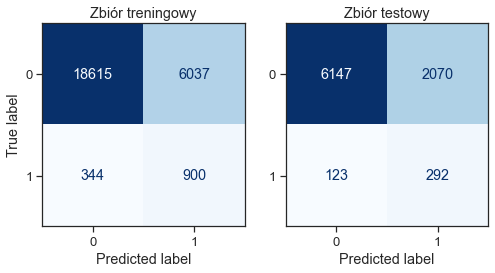

In [18]:
clf = LogisticRegression(penalty='l1', solver='liblinear', class_weight='balanced').fit(X_train, y_train)
print_precision_recall_report(clf, X_train, y_train, X_test, y_test)

Widzimy teraz, że *recall* jest całkiem-całkiem, natomiast siada nam zupełnie *precision*. Zapewne odpowiednio manewrując parametrem *class_weight* (bo przyjmuje on też ręcznie ustawione wagi) można by osiągnąć jakiś pożądany kompromis. 

Spójrzmy jeszcze na wpływ regulacji na model. Za główną miarę przyjmujemy `f1-score`.

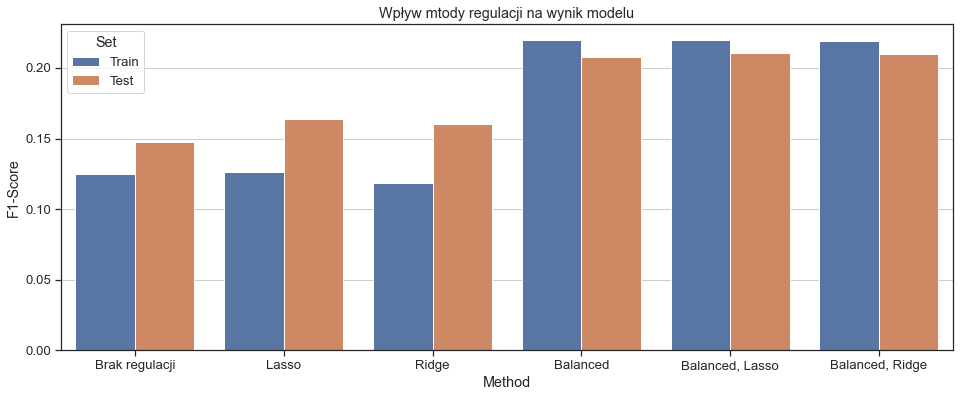

In [19]:
models = [
    LogisticRegression(penalty='none', solver='lbfgs'),
    LogisticRegression(penalty='l1', solver='liblinear'),
    LogisticRegression(penalty='l2', solver='liblinear'),
    LogisticRegression(penalty='none', solver='lbfgs', class_weight='balanced'),
    LogisticRegression(penalty='l1', solver='liblinear', class_weight='balanced'),
    LogisticRegression(penalty='l2', solver='liblinear', class_weight='balanced'),
]
methods = ['Brak regulacji', 'Lasso', 'Ridge', 'Balanced', 'Balanced, Lasso', 'Balanced, Ridge']

history = []

for i in range(len(models)):
    model = models[i].fit(X_train, y_train)
    train_f1 = f1_score(y_train, model.predict(X_train))
    test_f1 =  f1_score(y_test, model.predict(X_test))
    history.extend([(methods[i], train_f1, 'Train'), (methods[i], test_f1, 'Test')])
    
history_df = pd.DataFrame.from_records(history, columns=['Method', 'Score', 'Set'])
sns.barplot(data=history_df, x='Method', y='Score', hue='Set')
plt.ylabel('F1-Score')
plt.title('Wpływ mtody regulacji na wynik modelu')
plt.show()

Przyjęta metoda regulacji - brak, *lasso*, *ridge* - zdaje się mieć znikomy wpływ na model. Możliwe, że z odpowiednią wartością siły regulacji `C` metody *lasso* i *ridge* dałyby lepsze rezultaty.

#### Podsumowanie
Tak czy owak, regresja logistyczna to chyba za słaby model na ten przypadek. Dostrajając hiperparametry wyniki z pewnością uległyby poprawie, jednk raczej nie byłyby one zadowalające. Na słabość modelu mogą mieć wpływ *outliers*, które podobno zaburzają dopasowanie się tego modeli liniowych. 

## Support Vector Machine

### SVM z jądrem liniowym - `LinearSVC`

In [110]:
clf = LinearSVC(random_state=0, class_weight='balanced').fit(X_train, y_train)
clf.score(X_train, y_train)

0.7851791782514674

In [111]:
clf.score(X_test, y_test)

0.7796570898980537

------Zbiór treningowy-------
                  0         1
precision  0.979262  0.138940
recall     0.791092  0.668006
f1-score   0.875177  0.230035

--------Zbiór testowy--------
                  0         1
precision  0.978047  0.133202
recall     0.786175  0.650602
f1-score   0.871677  0.221130



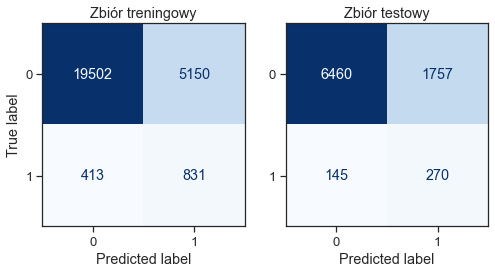

In [117]:
print_precision_recall_report(clf, X_train, y_train, X_test, y_test)

### SVM z jądrem wielomianowym

In [119]:
clf = SVC(random_state=0, kernel='poly', class_weight='balanced').fit(X_train, y_train)
clf.score(X_train, y_train)

0.8936129131912265

In [125]:
clf.score(X_test, y_test)

0.8755792400370713

------Zbiór treningowy-------
                  0         1
precision  0.977204  0.244158
recall     0.909460  0.579582
f1-score   0.942116  0.343579

--------Zbiór testowy--------
                  0         1
precision  0.967657  0.168844
recall     0.899355  0.404819
f1-score   0.932257  0.238298



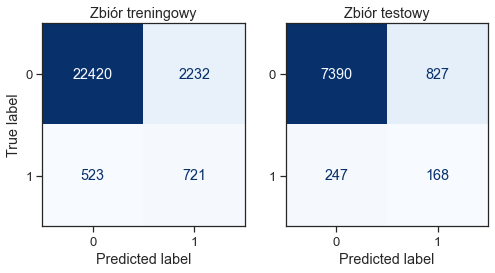

In [124]:
print_precision_recall_report(clf, X_train, y_train, X_test, y_test)

#### Podsumowanie

Metody *Support Vector Machines* dają nam odrobinę większą nadzieję niż regresja logistyczna. *F1-Score* jest odrobinę wyższy niż w regresji logistycznej, a bogactwo hiperparametrów sprawia, że dałoby się wycisnąć coś więcej. 

Nadal jednak osiągane wyniki nie są wystarczające, co zmusza nas do dalszych poszukiwań.

### Random Forest

In [55]:
rf = RandomForestClassifier(n_estimators = 80, min_samples_split=4, random_state = 0)
rf.fit(X_train,y_train)
rf.score(X_train, y_train)

0.9983781278962002

In [46]:
rf.score(X_test, y_test)

0.9528498609823911

------Zbiór treningowy-------
                  0         1
precision  0.999351  1.000000
recall     1.000000  0.987138
f1-score   0.999676  0.993528

--------Zbiór testowy--------
                  0         1
precision  0.954281  0.611111
recall     0.998296  0.053012
f1-score   0.975793  0.097561



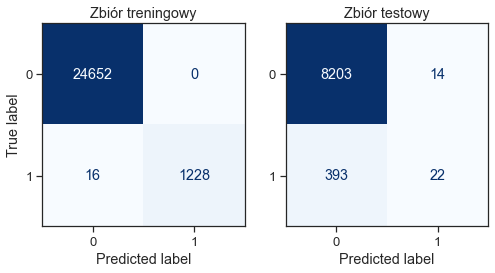

In [53]:
print_precision_recall_report(rf, X_train, y_train, X_test, y_test)

Wyniki uzyskane przy użyciu RandomForesta okazały się najsłabsze.
Co prawda, ten model jak żaden inny dopasował się do danych treningowych. 
Wydaje się, że ten model nie jest odpowiedni dla naszych danych, jednak można spróbować podziałać coś z hiperparametrami.

Co ciekawe, hiperparametr `class_weight` nie wydaje się mieć większego wpływu na działanie modelu.

------Zbiór treningowy-------
                  0         1
precision  0.999878  0.996787
recall     0.999838  0.997588
f1-score   0.999858  0.997188

--------Zbiór testowy--------
                  0         1
precision  0.953521  0.576923
recall     0.998661  0.036145
f1-score   0.975569  0.068027



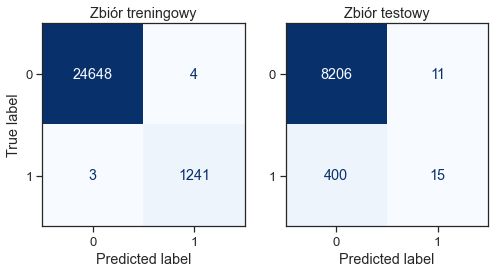

In [19]:
rf = RandomForestClassifier(n_estimators = 80, min_samples_split=4, random_state=0, class_weight='balanced')
rf.fit(X_train,y_train)
print_precision_recall_report(rf, X_train, y_train, X_test, y_test)

### XGBoost

In [34]:
xgb = xgboost.XGBClassifier(objective='binary:logistic', eval_metric='logloss', max_depth=2, use_label_encoder=False) 
xgb.fit(X_train,y_train)
xgb.score(X_train, y_train)

0.9582947173308619

In [35]:
xgb.score(X_test,y_test)

0.9570203892493049

------Zbiór treningowy-------
                  0         1
precision  0.958778  0.898058
recall     0.999148  0.148714
f1-score   0.978547  0.255172

--------Zbiór testowy--------
                  0         1
precision  0.957653  0.866667
recall     0.999026  0.125301
f1-score   0.977902  0.218947



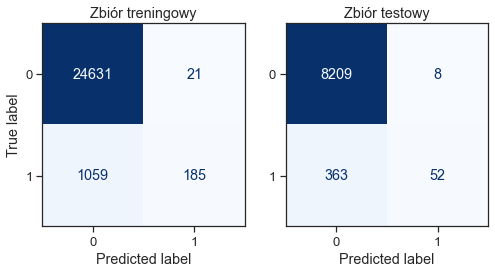

In [36]:
print_precision_recall_report(xgb, X_train, y_train, X_test, y_test)

------Zbiór treningowy-------
                  0         1
precision  0.993113  0.198276
recall     0.818919  0.887460
f1-score   0.897643  0.324134

--------Zbiór testowy--------
                  0         1
precision  0.985638  0.169329
recall     0.810150  0.766265
f1-score   0.889319  0.277366



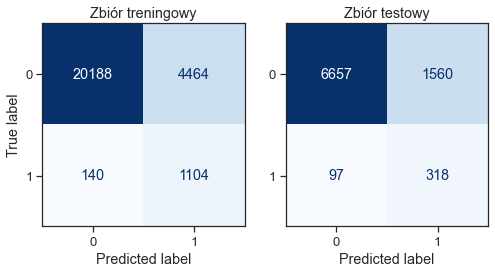

In [39]:
# z wagami klas
xgb = xgboost.XGBClassifier(objective='binary:logistic', max_depth=2, eval_metric='logloss', use_label_encoder=False, scale_pos_weight= (y==0).sum()/(y==1).sum()) 
xgb.fit(X_train,y_train)
print_precision_recall_report(xgb, X_train, y_train, X_test, y_test)

Wyniki uzyskane sodrobinę wyższe od tych uzyskanych przy pomocy LinearSVC. Z pewnością wypadają dużo lepiej niż LienarRegressin czy RandomForest. Precision jest jednak bardzo niski, co niezbyt zadowala. Prawdopodobnie strojąc hiperparametry możnaby wyciągnąc z tego modelu nieco więcej.

#### Podsumowanie
Wydaje się, że XGBoost to jest najlepszy wybór. Zajmiemy się nim w ramach kolejengo kamienia milowego.